# 2015 - 02
This one is really a stretch to make use of a quantum circuit.
* Create a circuit with enough qubits for the binary representation of each of the 3 numbers, plus ancilla bits for the multiplication
* Find product by using controlled binary multiplication by using Toffoli gates

### Binary multiplaction  
Decimal: $2 \times 3 = 6$  
Binary:  $10 \times 11 = 110$  
Normal long multiplication, just multiply each bit of the first by each bit of the second and add up  
```bash
  10  
 x11  
----  
  10  
+100  
----  
=110  
```
This translates exactly to controlled-controlled-not gates targetting a $|0⟩$ qubit (Toffoli gataes)
* 0x0=0 -or- leave the target qubit as $|0⟩$
* 0x1=0 -or- leave the target qubit as $|0⟩$
* 1x0=0 -or- leave the target qubit as $|0⟩$
* 1x1=1 -or- flip the target qubit to $|1⟩$

CCX produces the same as the binary multiplication above as both controls must be a 1 for a result of 1 in the ancilla bit. Then we would need to sum it up and handle carry over
* Sum is an traditional XOR gate
* Carry over is a quantum CCX gate

But instead of building a binary multiplier, we can use a built in RGQFTMultiplier (Quantum Fourier Transform Multiplier) to do the multiplication for us.

dimension: 10
dimension: 11


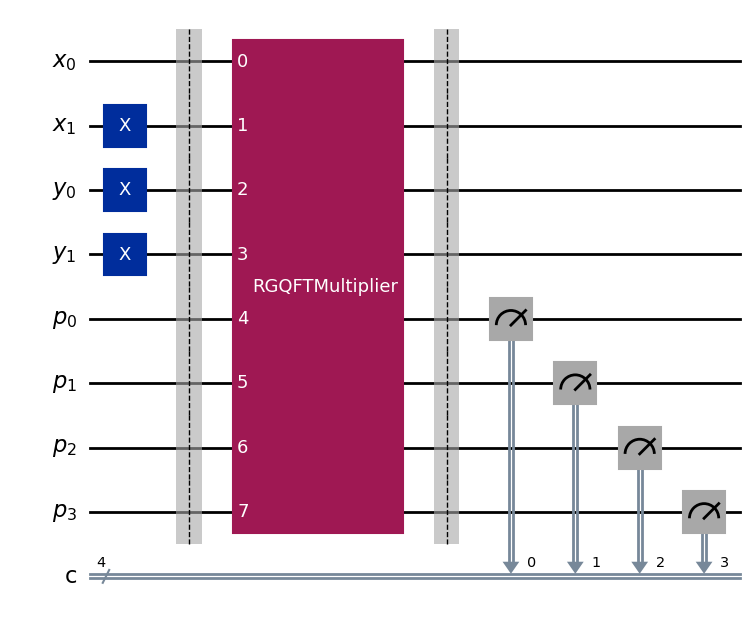

Counts: {'0110': 1}
X * Y = 6


In [91]:
from IPython.display import display
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.circuit.library import RGQFTMultiplier

def compute_product(x: int, y: int):
  factor_size = max(x, y).bit_length()

  q_x = QuantumRegister(factor_size, name='x')
  q_y = QuantumRegister(factor_size, name='y')
  q_p = AncillaRegister(factor_size * 2, name='p')
  c = ClassicalRegister(factor_size * 2, name='c')

  circuit = QuantumCircuit(q_x, q_y, q_p, c)

  def encode_dimension(value: int, reg: QuantumRegister):
    print(f"dimension: {format(value, f'0{factor_size}b')}")
    bin = f"{value:b}"
    for i, bit in enumerate(reversed(bin)): # reversed to start with LSB
      if bit == '1':
        circuit.x(reg[i]) # Apply x gate to flip bits to 1

  encode_dimension(x, q_x)
  encode_dimension(y, q_y)
  circuit.barrier()

  mult = RGQFTMultiplier(factor_size)
  circuit.compose(mult, inplace=True)
  circuit.barrier()

  circuit.measure(q_p, c)
  display(circuit.draw('mpl'))

  simulator = AerSimulator()
  compiled_circuit = transpile(circuit, simulator)
  result = simulator.run(compiled_circuit, shots=1).result()
  counts = result.get_counts()
  print("Counts:", counts)

  # Decode the measured result
  for output in counts:
      product = int(output, 2)
      print(f"X * Y = {product}")

compute_product(2, 3)